In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def correct_date(x):
    month = x[:3]
    day = x[3:5]
    year = x[5:7]
    return year +"-" + month + "-" + day


r1c1 = pd.read_csv("datasets/region1_company1.csv")
r1c1["Region"] = 1
r1c1["Company"] = 1
r2c1 = pd.read_csv("datasets/region2_company1.csv")
r2c1["Region"] = 2
r2c1["Company"] = 1
r1c2 = pd.read_csv("datasets/region1_company2.csv")
r1c2["Region"] = 1
r1c2["Company"] = 2
r2c2 = pd.read_csv("datasets/region2_company2.csv")
r2c2["Region"] = 2
r2c2["Company"] = 2
df = pd.concat([r1c1,r2c1,r1c2,r2c2],axis=0)
df["Date"] = pd.to_datetime(df["Date"].apply(correct_date))
df["price"] = df["Sales_USD"]/df["Sales_U"]

Task 1: Construct time-series plots of sales and prices for Company 1 in Region 1 and 2. Repeat the exercise for Company 2.

Describe the differences or similarities between Company 1 and 2 pricing policies.

-> Both companies keep their prices more stable in Region 1, with a lower standard deviation. 
Company 1 has applied significant discounts in some weeks, reaching up to 50 %. Company 2 has always kept its prices above 0.9 $/lbs.



In [2]:

def compare_regions_time_series(df, company, value):
    
    fig = plt.figure(figsize=(5, 4))

    for region in [1,2]:
        dfcr = df[(df["Company"]==company) & (df["Region"]==region)]
        plt.plot(dfcr.Date, dfcr[value], color = {1: "blue", 2: "red"}[region], label = "Region "+str(region),
                linewidth=1)

    plt.title("Company {} - {}".format(company, value))
    plt.xlabel('Date')
    plt.ylabel(value)
    plt.xticks(rotation=90)


    plt.legend()

    plt.tight_layout()

    plt.show() 

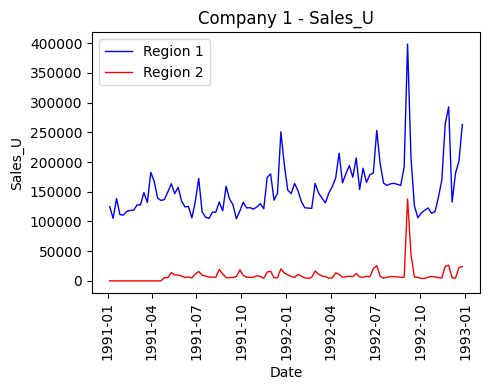

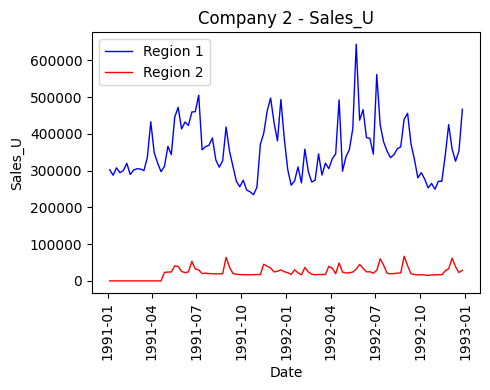

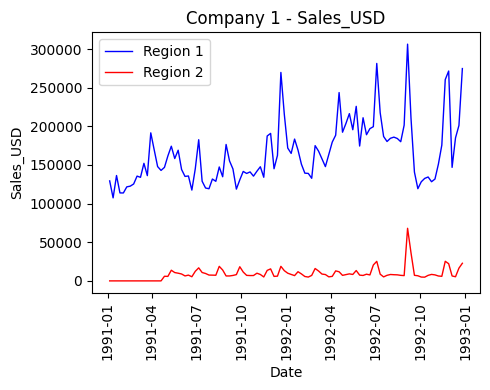

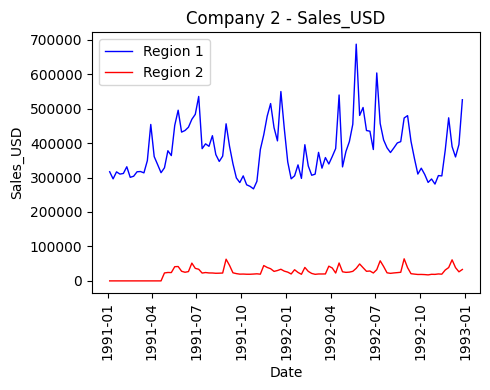

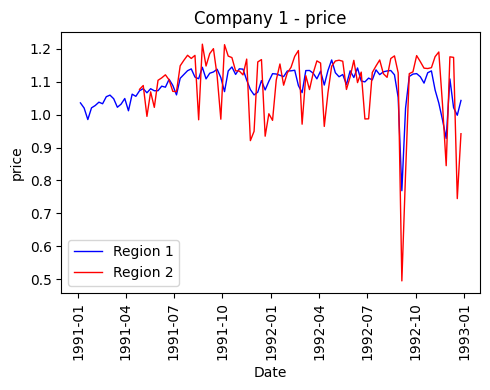

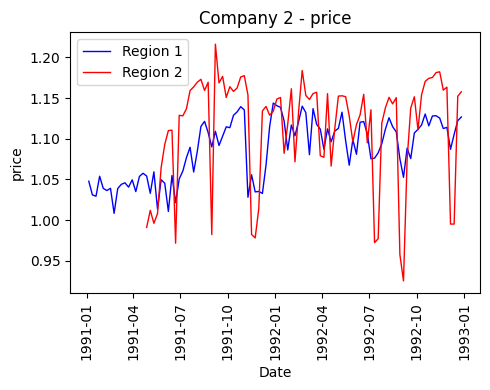

In [3]:
for value in ["Sales_U", "Sales_USD", "price"]:
    for company in [1, 2]:
        compare_regions_time_series(df, company, value)

In [4]:
df.groupby(["Region", "Company"])["price"].describe()

count      mean       std       min       25%       50%  \
Region Company                                                            
1      1        104.0  1.088719  0.054266  0.768942  1.061713  1.106540   
       2        104.0  1.086778  0.036779  1.008224  1.053772  1.092727   
2      1         88.0  1.094971  0.111722  0.494999  1.070636  1.127675   
       2         88.0  1.114487  0.066829  0.925153  1.090196  1.138857   

                     75%       max  
Region Company                      
1      1        1.126358  1.166239  
       2        1.116062  1.143827  
2      1        1.165281  1.214205  
       2        1.158433  1.216236

Task 2: Construct scatter-plots of sales versus prices for Company 1 in Region 1 and Region 2 separately. Repeat the exercise for Company 2. 

Is there evidence for a negatively sloped demand-curve in the data?

-> Yes, the trending line (confidence interval = 95 %) has a negative slope in the four plots.

Eye-balling these plots, does demand appear more elastic in Region 1 or 2?

-> Demand seems more elastic in Region 2 (attention: the scales used for axis X and Y are different in each plot).


In [5]:


def plot_price_sales(df, company, region):
    
    fig = plt.figure(figsize=(5, 4))
    dfcr = df[(df["Company"]==company) & (df["Region"]==region)]
    
    aux = dfcr.dropna(subset="price").sort_values("price")
    aux = aux[(np.abs(stats.zscore(aux["price"])) < 3)] #clean outliers

    sns.regplot(x=aux["price"], y=aux["Sales_U"], ci=95, truncate=False)

    plt.title("Company {} - Region {}: Sales_U - price".format(company, region))
    plt.xlabel('price')
    plt.ylabel("Sales_U")

    plt.show()




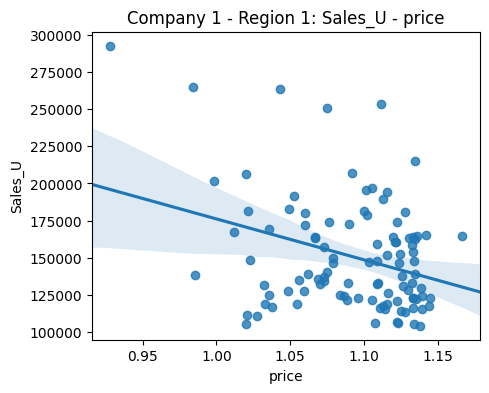

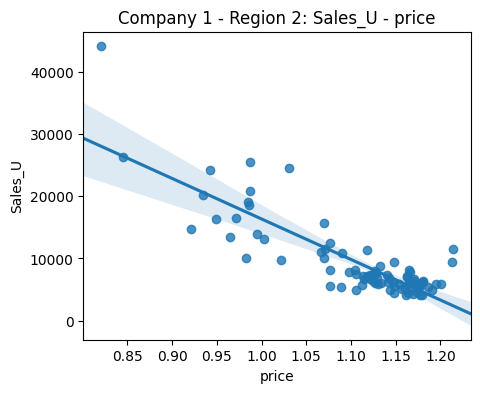

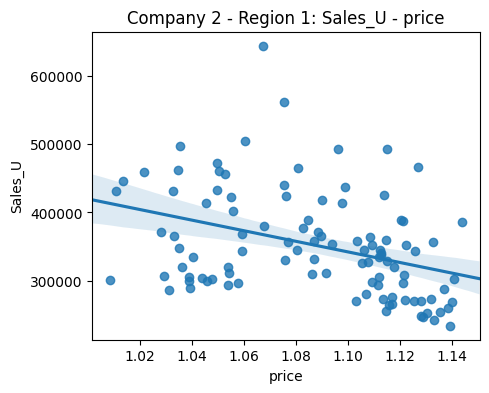

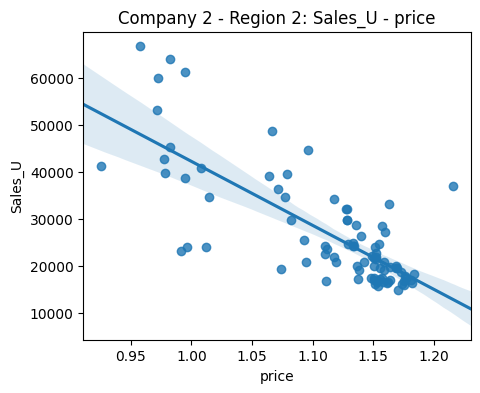

In [6]:
for company in [1,2]:
    for region in [1,2]:
        plot_price_sales(df, company, region)

Task 3: Estimate the price elasticity of demand for Company 1 and 2 at Region 1 and
2 (four different demand models). Is the demand elasticity higher (in absolute
magnitude) in Region 1 or 2?

-> Elasticity is higher in Region 2

In [7]:

def price_elasticity(df, company, region):
    
    dfcr = df[(df["Company"]==company) & (df["Region"]==region)]
    dfcr["log_Sales_U"] = dfcr["Sales_U"].apply(np.log)
    dfcr["log_price"] = dfcr["price"].apply(np.log)

    aux = dfcr.dropna(subset="price").sort_values("price") #clean nans
    aux = aux[(np.abs(stats.zscore(aux["price"])) < 3)] #clean outliers

    #linear regression
    aux["1"] = 1 #necessary to add intercept
    model = sm.OLS(aux["log_Sales_U"],aux[["1", "log_price"]]) 
    
    results = model.fit()
    conf_int = results.conf_int(alpha=0.05).loc["log_price"].to_list()
    elasticity = results.params["log_price"]

    return {"company":company,"region": region,"elasticity":elasticity,"conf_int_95_min": conf_int[0],"conf_int_95_max": conf_int[1]}




In [8]:
aux = []
for company in [1,2]:
    for region in [1,2]:
        aux.append(price_elasticity(df, company,region))
df_el = pd.DataFrame(aux)
df_el

C:\Users\pablo\AppData\Local\Temp\ipykernel_45612\1176314271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcr["log_Sales_U"] = dfcr["Sales_U"].apply(np.log)
C:\Users\pablo\AppData\Local\Temp\ipykernel_45612\1176314271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcr["log_price"] = dfcr["price"].apply(np.log)
C:\Users\pablo\AppData\Local\Temp\ipykernel_45612\1176314271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,company,region,elasticity,conf_int_95_min,conf_int_95_max
0,1,1,-1.591174,-2.617380,-0.564968
1,1,2,-5.340259,-6.055502,-4.625017
2,2,1,-2.376539,-3.469345,-1.283734
3,2,2,-4.583590,-5.431651,-3.735528


Task 4: Compute the % change in unit sales for a 10% increase in the price of
Company 1 at Region 1.

-> A 10 % increase in the price of Company 1 at region 1 causes a 15.9 % decrease in unit sales (min 5.65 %, max 26.2 %, CI = 95 %)

In [9]:
df_el.iloc[0, -3:]*10

elasticity        -15.911740
conf_int_95_min   -26.173799
conf_int_95_max    -5.649680
Name: 0, dtype: float64

Task 5: You may be called upon to report to your manager whether your brand is
vulnerable to a competitor's pricing policies. That is, to what extent does the
demand for your product depend on (or is affected by) your competitors'
pricing policy? 

-> I have plotted the market share of company 1 in each market as a function of the price difference and I have fitted a fourth degree polinomial. When the difference between prices changes, the market share also changes.

Which brand is more "vulnerable"? Be specific as to why.

-> I would say that the brand 1 is more vulnerable:
- When p1 = p2, its share is between 20 and 30 %
- The line is almost straight close between p1 - p2 = -0.05 and p1 - p2 = 0.05
- As a consequence, when there is a difference of prices, the market share variation (share(t=t0+1) - share(t=t0)/share(t=t0)) is greater for the company 1.

In [10]:
def plot_share_price_difference(df, region):
    df_c1 = df[(df["Region"]==region)&(df["Company"]==1)]
    df_c2 = df[(df["Region"]==region)&(df["Company"]==2)]
    df_c = pd.merge(df_c1, df_c2, on = ["Date","Region"])
    df_c["Sales_1/(Sales_1+Sales_2)"] = df_c["Sales_U_x"]/(df_c["Sales_U_x"]+df_c["Sales_U_y"])
    df_c["price_1 - price_2"] = df_c["price_x"]-df_c["price_y"]
    
    fig = plt.figure(figsize=(5, 4))
    

    plt.title("Region {}: Market-share vs price difference".format(region))
    plt.xlabel('price_c1 - price_c2')
    plt.ylabel("Sales_c1/total_sales")
    
    aux = df_c.dropna(subset="price_1 - price_2").sort_values("price_1 - price_2")
    aux = aux[aux["price_1 - price_2"].apply(abs)<0.15] #only central points
    plt.scatter(aux["price_1 - price_2"], aux["Sales_1/(Sales_1+Sales_2)"], linewidths=0.01)

    x = aux["price_1 - price_2"]
    y = aux["Sales_1/(Sales_1+Sales_2)"]
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")

    plt.tight_layout()

    plt.show()


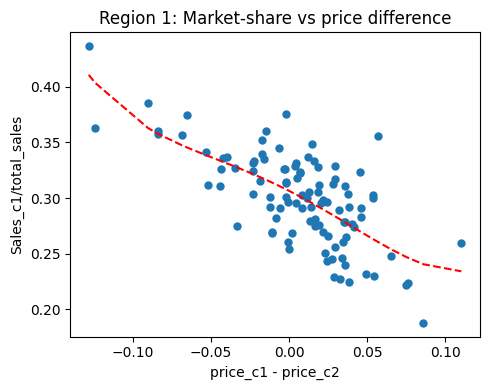

In [11]:
plot_share_price_difference(df, 1)

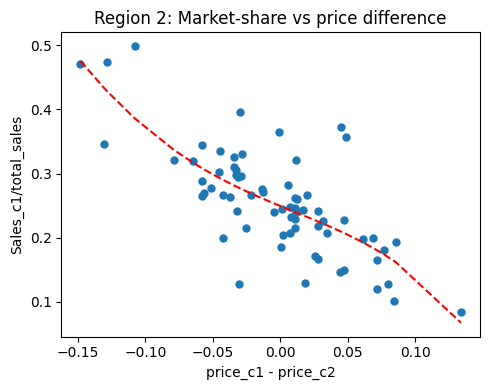

In [12]:
plot_share_price_difference(df, 2)

Task 6: While making a crucial presentation of the above results in front of your team,
your analyst colleague questions your results as follows: "This is all fine. But,
you know, you're missing a lot of variables in your so-called regression model.
For instance, the sales of Company 1 at Region 2 are clearly affected by store
traffic. When it snows, less people visit Region 2, and you don't have such
factors -- the weather, temperature, traffic congestions, etc. So aren't your
cross-price effects all wrong?" Is your colleague right or wrong?

-> My colleague is wrong. In order to avoid those problems I was working with the market share instead of sales numbers.

Other plots

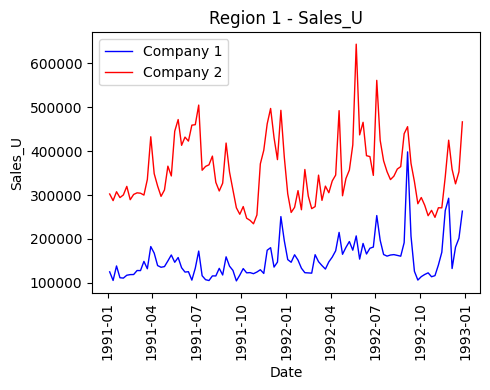

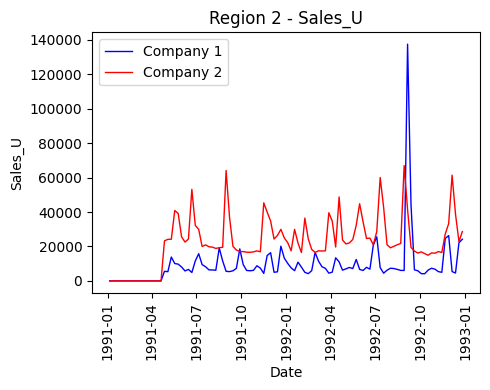

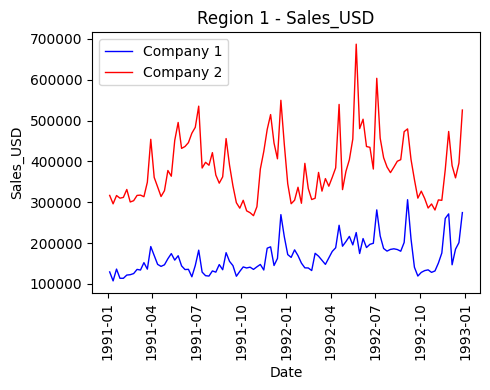

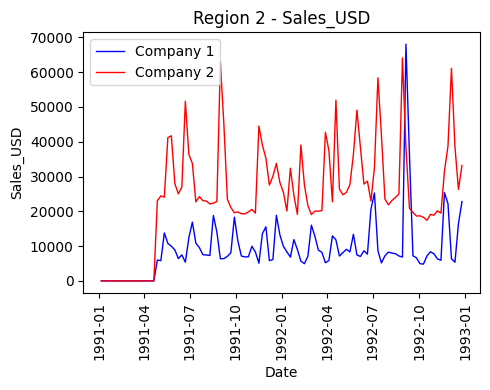

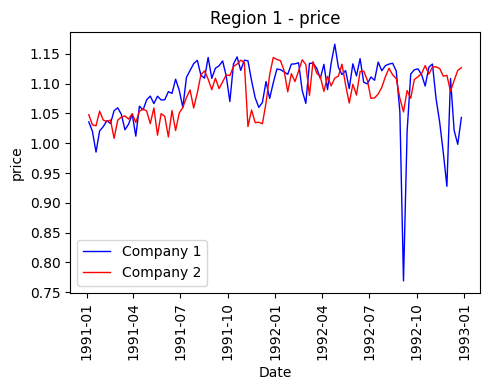

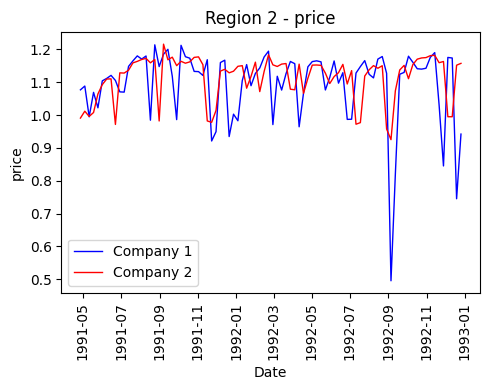

In [13]:
def compare_companies_time_series(df, region, value):
    
    fig = plt.figure(figsize=(5, 4))

    for company in [1,2]:
        dfcr = df[(df["Company"]==company) & (df["Region"]==region)]
        plt.plot(dfcr.Date, dfcr[value], color = {1: "blue", 2: "red"}[company], label = "Company "+str(company),
                linewidth=1)

    plt.title("Region {} - {}".format(region, value))
    plt.xlabel('Date')
    plt.ylabel(value)
    plt.xticks(rotation=90)


    plt.legend()

    plt.tight_layout()

    plt.show()

for value in ["Sales_U", "Sales_USD", "price"]:
    for region in [1, 2]:
        compare_companies_time_series(df, region, value)